This notebook contains my learning and experimentation with machine learning concepts. I explore an antimicrobial resistance dataset, perform data exploration and preprocessing, and train a Random Forest classifier to understand model behaviour, evaluation metrics, and feature importance in a biological context.



In [ ]:
# Import pandas to read CSV file
import pandas as pd


In [ ]:
data = pd.read_csv("../data/Kaggle_AMR_Dataset_v1.0.csv")

# Quick look at the data
print(data.shape)
data.head()
data.columns

(50, 112)


Index(['Isolate_ID', 'Genome_Length_BP', 'GC_Content_Percent',
       'gene_APH(3'')-Ib', 'gene_APH(3')-Ia', 'gene_APH(6)-Id', 'gene_CMY-59',
       'gene_CRP', 'gene_CTX-M-14', 'gene_CTX-M-15',
       ...
       'biosample', 'bioproject', 'taxonomy', 'collection_year',
       'collection_month', 'collection_season', 'host_standardized',
       'isolation_source_standardized', 'total_amr_genes',
       'total_resistance_classes'],
      dtype='str', length=112)

In [ ]:
# Summary statistics of the total resistance classes
data["total_resistance_classes"].describe()

count    50.000000
mean     23.180000
std       0.595562
min      21.000000
25%      23.000000
50%      23.000000
75%      23.000000
max      25.000000
Name: total_resistance_classes, dtype: float64

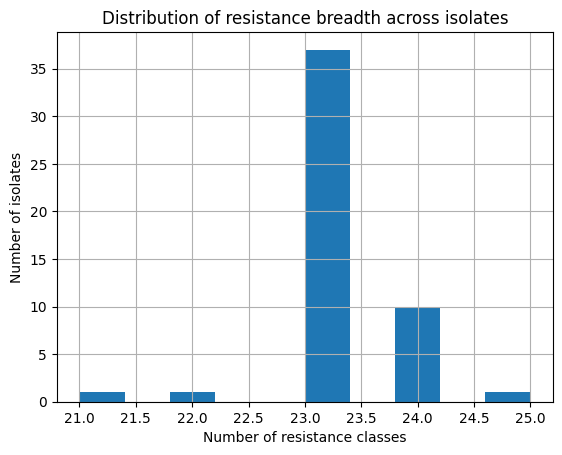

In [ ]:
# Plot the distribution of total resistance classes
import matplotlib.pyplot as plt

data["total_resistance_classes"].hist(bins=10)
plt.xlabel("Number of resistance classes")
plt.ylabel("Number of isolates")
plt.title("Distribution of resistance breadth across isolates")
plt.savefig("../results/fig1_resistance_distribution.png", dpi=300)
plt.show()

This plot shows how many antibiotic resistance classes are present in each isolate. Most isolates have resistance to around 23 classes, with only small differences between samples. This means that many isolates already have a broadly resistant profile, and there is limited variation in overall resistance levels across the dataset.

From a machine learning learning perspective, this is important because the model cannot rely only on the total number of resistance classes to make predictions. Instead, it needs to learn differences in the presence or absence of specific resistance genes. This helps me understand how models use detailed feature-level information rather than simple summary values when making predictions.

In [75]:
# I am splitting the data into two groups : those with above meadian resistance depth and those with below median resistance depth
# This is a very simple way to create a binary classification problem. I can then use this as the target variable for my machine learning models.
# I chose this approach because it is simple and it allows me to create a balanced dataset. If I were to use a different threshold, I might end up with a very imbalanced dataset, which would make it harder to train my models.
# also my dataset is not very large, so I want to make sure I have enough samples in each class to train my models effectively.
# and most importantly my dataset has most isolates have resistance around 23 classes, so using the median as a threshold makes sense in this context.
y = (data["total_resistance_classes"] >
     data["total_resistance_classes"].median()).astype(int)
y.value_counts()

total_resistance_classes
0    39
1    11
Name: count, dtype: int64

For learning purposes, a binary target variable was created by splitting isolates based on the median number of resistance classes. This allows exploration of classification models but does not represent a clinical definition of multidrug resistance.


In [76]:
# I am taking the gene features as my input and my dataset contains it as gene_* columns
X = data[[c for c in data.columns if c.startswith("gene_") ]]
# Check the data types of the features and look for any potential issues
print(X.dtypes.value_counts())
# Check for missing values
print("Total missing values:", X.isna().sum().sum())

int64    64
Name: count, dtype: int64
Total missing values: 0


# Model training a evaluation

Now, I train a machine learning model to predict whether an isolate belongs to a higher resistance or lower resistance group based on gene presence features.

first i split dataset to test and training sets using train_test_split. 80% data is used to train and 20% used to test. But this datatset is very small this is a bigg limitation to aknowledge. The stratify=y ensures that the prorpotion of both classes remain similiar in both training and testing sets. This prevent biased evaluation when classes are imbalenced.

A randomForest Classifier is then used to train. It is suitable for this dataset because it handles binary features well, is robust to small datasets, and can capture non-linear relationships between resistance genes. The parameter class_weight="balanced" helps the model handle unequal class sizes by giving more importance to the minority class during training.

After training, the model predicts probabilities for the test data using predict_proba. These probabilities are used to calculate the ROC-AUC score, which measures how well the model separates the two classes across different decision thresholds. In addition, the F1 score is calculated using predicted class labels, providing a balance between precision and recall.

Together, these metrics help evaluate both the discrimination ability of the model (ROC-AUC) and its classification performance (F1 score).

In [77]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,f1_score

X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=200,
    class_weight="balanced",random_state=42)
model.fit(X_train,y_train)

pred = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test,pred)

print("RF ROC-AUC:", roc_auc_score(y_test, pred))
print("RF F1:", f1_score(y_test, model.predict(X_test)))

RF ROC-AUC: 1.0
RF F1: 1.0


The Random Forest model achieved an ROC-AUC score of 1.0 and an F1 score of 1.0 on the test dataset. This indicates that the model was able to perfectly separate the higher-resistance and lower-resistance groups for the samples in the test set.

However, since this dataset is small and contains features that are directly related to resistance (presence of known resistance genes), this perfect performance likely reflects strong patterns already present in the data rather than a model that would generalize perfectly to new datasets. In small biological datasets, models can sometimes learn dataset-specific patterns very easily, which may lead to overly optimistic performance estimates.

From a learning perspective, this result helps demonstrate how machine learning models can capture relationships between gene presence and resistance profiles, while also highlighting the importance of careful evaluation and awareness of potential overfitting.

In [61]:
from sklearn.metrics import confusion_matrix, classification_report

# Print confusion matrix and classification report
print("Confusion matrix:\n", confusion_matrix(y_test, model.predict(X_test)))
print("\nClassification report:\n", classification_report(y_test, model.predict(X_test), digits=3))


Confusion matrix:
 [[8 0]
 [0 2]]

Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      1.000     1.000     1.000         2

    accuracy                          1.000        10
   macro avg      1.000     1.000     1.000        10
weighted avg      1.000     1.000     1.000        10



The confusion matrix shows that the model correctly classified all samples in the test set. Out of 10 test isolates, 8 lower-resistance isolates (class 0) and 2 higher-resistance isolates (class 1) were predicted correctly, with no false positives or false negatives. This means the model made no classification errors on the test data.

The classification report reflects this result, where precision, recall, and F1-score are all equal to 1.0 for both classes. Precision of 1.0 indicates that all predicted labels were correct, while recall of 1.0 shows that all true samples from each class were successfully identified by the model.

However, because the dataset is small and the features directly represent known resistance genes, this perfect performance should be interpreted carefully. The model may be learning strong patterns specific to this dataset rather than generalizable biological rules. From a learning perspective, this result demonstrates how machine learning models can effectively separate classes when informative features are available, while also highlighting the importance of evaluating models on larger and more diverse datasets.

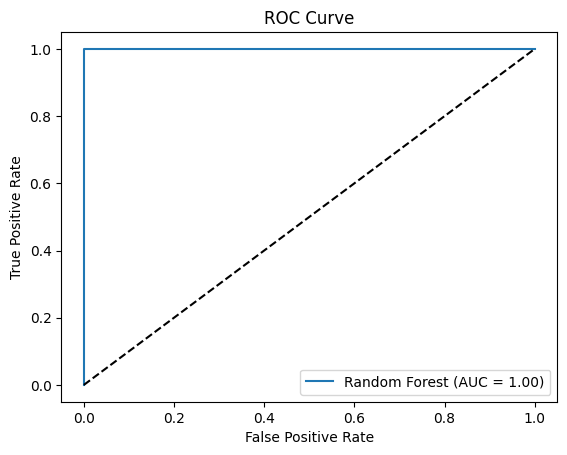

In [62]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig("../results/fig3_roc_curve.png", dpi=300)
plt.show()

The ROC (Receiver Operating Characteristic) curve shows how well the Random Forest model distinguishes between the lower-resistance and higher-resistance isolates across different classification thresholds. The curve lies along the top-left corner of the plot, and the area under the curve (ROC-AUC) is 1.0, indicating perfect separation between the two classes in the test dataset.

The result demonstrates that the model can successfully learn strong patterns present in the dataset, but it does not necessarily mean that the model would achieve the same performance on unseen or more diverse data.

From a learning perspective, this plot helps illustrate how ROC curves are used to evaluate classification performance and how model discrimination ability can be visualized beyond simple accuracy metrics.

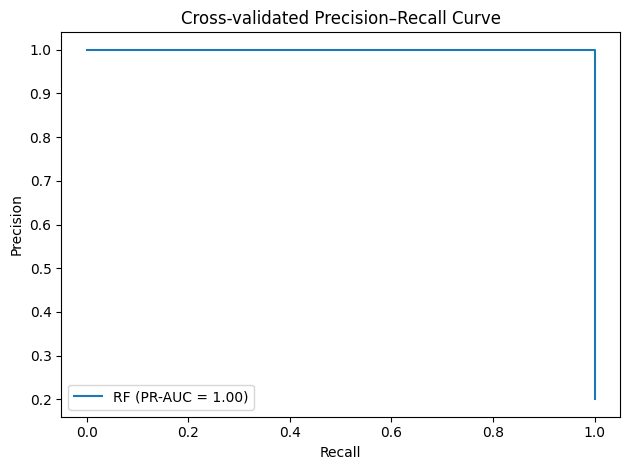

In [63]:
from sklearn.metrics import precision_recall_curve, average_precision_score
# Compute precision-recall curve and average precision score
precision, recall, _ = precision_recall_curve(y_test, pred)
pr_auc = average_precision_score(y_test, pred)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, label=f"RF (PR-AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Cross-validated Precision–Recall Curve")
plt.legend()
plt.tight_layout()

plt.savefig("../results/fig4_pr_curve_cv.png", dpi=300)
plt.show()

The Precision–Recall (PR) curve shows how well the model identifies higher-resistance isolates while balancing precision (how many predicted positives are correct) and recall (how many true positives are detected). In this plot, the curve remains close to the top-right corner, and the PR-AUC score is 1.0, indicating that the model achieves perfect precision and recall across classification thresholds during cross-validation.

This means that, within this dataset, the model is able to correctly identify higher-resistance isolates without incorrectly labeling lower-resistance isolates as positive. Using cross-validation helps provide a more stable estimate of performance compared to a single train–test split.

In next step, permutation importance is used to understand which features (genes) are most important for the model’s predictions.

After the Random Forest model has been trained, permutation importance measures how much the model’s performance decreases when the values of a single feature are randomly shuffled. Shuffling a feature breaks its relationship with the target variable. If the model performance drops significantly after shuffling a feature, it means that the feature was important for making correct predictions. If there is little or no change in performance, the feature is likely less important.

The function permutation_importance repeats this process multiple times (n_repeats=50) to obtain stable importance estimates. The F1 score is used as the evaluation metric because it balances precision and recall for the classification task.

The results are then stored in a dataframe containing feature names and their average importance values. Finally, the features are sorted in descending order so that the most influential genes for predicting resistance appear at the top.

From a learning perspective, this step helps understand how machine learning models use individual features and allows model predictions to be connected back to biological interpretation.

In [64]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm = permutation_importance(
    model,
    X,
    y,
    n_repeats=50,
    random_state=42,
    scoring="f1"
)
# Create a DataFrame to display feature importance
imp = pd.DataFrame({
    "feature": X.columns,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

# Display the top 15 most important features
imp.head(15)


,feature,importance
0,gene_APH(3'')-Ib,0.0
1,gene_APH(3')-Ia,0.0
2,gene_APH(6)-Id,0.0
3,gene_CMY-59,0.0
4,gene_CRP,0.0
5,gene_CTX-M-14,0.0
6,gene_CTX-M-15,0.0
7,gene_CTX-M-27,0.0
8,gene_Escherichia_coli_acrA,0.0
9,gene_Escherichia_coli_ampC,0.0


In this result, all features show an importance value of 0.0, which means that shuffling any individual feature did not reduce the model’s performance. In other words, the model’s predictions did not depend strongly on any single gene when evaluated individually.

possible reasons for this included :
1) many genes occur in same isolates. when one gene is shuffled other genes compensate for this. As seen from the datset where almost all isolates are in same resitance classes.
2) very small datset size of 50. making it difficult to identify a dominant feature.
3) strong overal signal in datset
Because resistance genes are already directly related to the prediction target, the model may rely on combinations of features rather than any single gene.

this result shows that feature importance does not always identify individual “key genes,” especially when features are biologically related or frequently co-occur.


In this step, I extract feature importance values directly from the trained Random Forest model. Random Forest calculates feature importance based on how much each feature contributes to reducing prediction error while building decision trees. Features that help split the data more effectively during training receive higher importance scores.

This analysis helps identify which genes the model relied on most when making predictions. By ranking features according to their importance, it becomes possible to understand which resistance genes contribute most strongly to separating higher-resistance and lower-resistance isolates within this dataset.

This step is also useful for learning purposes because it allows comparison between different methods of model interpretation. Earlier, permutation importance was used to measure how model performance changes when features are shuffled. In contrast, Random Forest feature importance reflects how frequently and effectively features were used during model training. Comparing these approaches helps demonstrate that different interpretation methods can produce different results, especially in biological datasets where many features are correlated.

In [58]:

rf_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

rf_importance.head(15)

,feature,importance
86,class_sulfonamide,0.175488
58,gene_sul2,0.162119
2,gene_APH(6)-Id,0.141564
0,gene_APH(3'')-Ib,0.118416
37,gene_floR,0.067355
59,gene_tet(A),0.065941
62,gene_ugd,0.053583
57,gene_sul1,0.028216
54,gene_mphB,0.026781
60,gene_tet(B),0.026412


The most important features include genes such as APH variants, sul1/sul2, tet(A)/tet(B), floR, and mphA/mphB, which are known antimicrobial resistance genes associated with resistance to aminoglycosides, sulfonamides, tetracyclines, phenicols, and macrolides. This suggests that the model is primarily using the presence of accessory resistance genes to identify isolates with broader resistance profiles.

From a biological perspective, this is reasonable because multidrug resistance in bacteria is often driven by the accumulation of multiple resistance genes rather than a single mechanism.

These results should be interpreted as indicators of predictive relevance within this dataset rather than definitive evidence of gene importance in all bacterial populations.

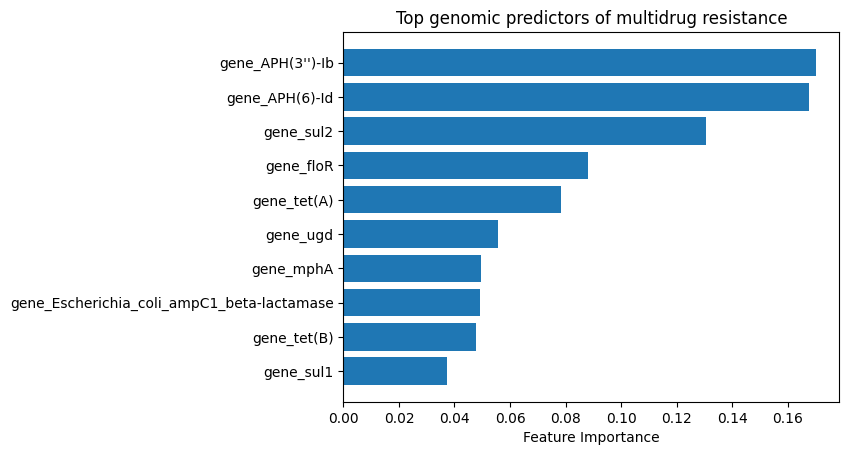

In [ ]:
from matplotlib import pyplot as plt
# Plot the top 10 most important features
top = rf_importance.head(10)

plt.barh(top["feature"], top["importance"])
plt.xlabel("Feature Importance")
plt.title("Top genomic predictors of multidrug resistance")
plt.savefig("../results/fig5_feature_importance.png", dpi=300)
plt.gca().invert_yaxis()
plt.show()

# Conclusion

In this notebook, I explored the application of machine learning methods to a biologically meaningful antimicrobial resistance (AMR) dataset as part of my learning process. A binary classification problem was created by separating isolates into higher- and lower-resistance groups based on the median number of resistance classes. Several machine learning concepts were practiced, including dataset preparation, train–test splitting, model training, evaluation using ROC-AUC and F1 score, cross-validation, and feature importance analysis.

The Random Forest model achieved very high performance on this dataset, demonstrating that machine learning models can effectively learn patterns between resistance gene profiles and resistance outcomes when informative features are available. The workflow also helped illustrate how model evaluation metrics and visualization tools such as ROC and Precision–Recall curves are used to assess classification performance.

# Interpretation

The results suggest that prediction of higher resistance in this dataset is mainly driven by the presence of accessory antimicrobial resistance genes, such as aminoglycoside-modifying enzymes, sulfonamide resistance genes, tetracycline resistance genes, and other acquired resistance determinants. Many intrinsic or core resistance-related genes were present across most isolates and therefore contributed less to distinguishing between classes.

From a learning perspective, this demonstrates that machine learning models often rely on features that vary between samples rather than features that are universally present. The analysis also highlights how model interpretation methods, such as Random Forest feature importance and permutation importance, can provide insight into which features influence predictions and how these relate to known biological mechanisms.

# Limitations

Several limitations should be considered when interpreting these results:

1) The dataset is small (50 isolates), which increases the risk of overfitting and limits generalization to new datasets.

2) Resistance genes in this dataset are already known and annotated, meaning the model is learning established biological relationships rather than discovering new resistance mechanisms.

3) The binary target variable was engineered using a median split and does not represent a clinical definition of multidrug resistance.

4) High model performance likely reflects strong existing patterns in the dataset rather than a model that would perform equally well on more diverse bacterial populations.

5) Feature importance values indicate predictive relevance within this dataset and should not be interpreted as proof of biological causation.

# Learning Outcome

This notebook helped build practical understanding of how machine learning workflows are applied to biological data, how model performance should be interpreted carefully, and how computational results can be connected back to biological context while acknowledging limitations.
